In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
import ta, math
import numpy as np

class BackTesting:
    def __init__(self, ticker, start_date, end_date, train_end, initial_investment, params):
        self.ticker = ticker
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.train_end = pd.to_datetime(train_end)
        self.initial_investment = initial_investment
        self.params = params

        # These will be set later
        self.df = None               # data with indicators
        self.buy_signal = None
        self.sell_signal = None
        self.trades = []            # list of trade dictionaries
        self.portfolio = None       # portfolio time series
        self.train_trades = None
        self.test_trades = None
        
        
    def get_period_dates(self, period):
        if period == "train":
            start_date = self.portfolio.index[0]
            end_date = self.train_end
        elif period == "test":
            start_date = self.train_end + pd.Timedelta(days=1)
            end_date = self.portfolio.index[-1]
        elif period == "all":
            start_date = self.portfolio.index[0]
            end_date = self.portfolio.index[-1]
        else:
            raise ValueError("Period must be 'train', 'test', or 'all'.")
        return start_date, end_date

        
    def prepare_data(self):
        df = yf.download(self.ticker, start=self.start_date, end=self.end_date, progress=False)

        # Drop ticker level if multi-indexed (only applies to multi-ticker download)
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel("Ticker")

        # Compute indicators
        df["ibs"] = (df["Close"] - df["Low"]) / (df["High"] - df["Low"])

        atr = AverageTrueRange(high=df["High"], low=df["Low"], close=df["Close"], window=14)
        df["ATR"] = atr.average_true_range()
        df["ATR_mean50"] = df["ATR"].rolling(50).mean()

        df["STD"] = df["Close"].rolling(window=20).std()
        df["SMA20"] = df["Close"].rolling(window=20).mean()
        df["SMA50"] = df["Close"].rolling(window=50).mean()
        df["SMA200"] = df["Close"].rolling(window=200).mean()

        df["Upper Band"] = df["SMA20"] + 2 * df["STD"]
        df["Lower Band"] = df["SMA20"] - 2 * df["STD"]
        
        def compute_rsi(series, window):
            delta = series.diff()

            gain = delta.clip(lower=0)
            loss = -delta.clip(upper=0)

            avg_gain = gain.rolling(window=window).mean()
            avg_loss = loss.rolling(window=window).mean()

            rs = avg_gain / avg_loss
            rsi = 100 - (100 / (1 + rs))

            return rsi

        df["rsi2"] = compute_rsi(df["Close"], window=2)
        df["rsi4"] = compute_rsi(df["Close"], window=4)
        df["rsi10"] = compute_rsi(df["Close"], window=10)
        
        
        def kaufman_efficiency_ratio(price_series, window=20):
        
            net_change = price_series.diff(window).abs()
            total_volatility = price_series.diff().abs().rolling(window=window).sum()
            er = net_change / total_volatility
            return er
        
        df["ER10"] = kaufman_efficiency_ratio(df["Close"], window=10)
        
        df.dropna(inplace=True)
        self.df = df
        
        
    def run_backtest(self):

        df = self.df.copy()
        in_position = False
        equity = self.initial_investment
        no_of_shares = 0
        entry_price = 0
        entry_date = None
        exit_price = 0
        exit_date = None
        days_held = 0
        consecutive_losses = 0
        max_consec_losses = 0

        portfolio_history = []
        trade_log = []
        
        pending_entry = False
        pending_entry_index = None
        
        pending_exit = False
        pending_exit_index = None

        for i in range(3, len(df)):
            current_date = df.index[i]
            current_price = df["Close"].iloc[i]
            
            # Check if there is a pending entry to execute
            if pending_entry and i == pending_entry_index:
            # Execute entry at today's open (since signal was generated previous day)
                entry_price = df["Open"].iloc[i]
                entry_date = df.index[i]
                no_of_shares = math.floor(equity / entry_price)
                equity -= no_of_shares * entry_price
                days_held = 0
                in_position = True
                pending_entry = False
                pending_entry_index = None
                
            elif pending_exit and i == pending_exit_index and in_position:
            # Execute exit at today's open (since signal was generated previous day)
                exit_price = df["Open"].iloc[i]
                exit_date = df.index[i]
                equity += no_of_shares * exit_price
                
                pct_return = (exit_price - entry_price) / entry_price * 100
                trade_log.append({
                    "Entry Date": entry_date,
                    "Exit Date": exit_date,
                    "Entry Price": entry_price,
                    "Exit Price": exit_price,
                    "Return %": pct_return,
                    "Hold Days": days_held })

                if pct_return < 0:
                    consecutive_losses += 1
                    max_consec_losses = max(max_consec_losses, consecutive_losses)
                else:
                    consecutive_losses = 0

                no_of_shares = 0
                in_position = False
                entry_price = 0
                entry_date = None
                days_held = 0
                pending_exit = False
                pending_exit_index = None
            
            # Use open price if it’s the day of entry or exit
            if df.index[i] == entry_date or df.index[i] == exit_date:
                current_price = df["Open"].iloc[i]
            else:
                current_price = df["Close"].iloc[i]

            current_value = equity + no_of_shares * current_price if in_position else equity
            
            portfolio_history.append((df.index[i], current_value))
            

            # ---- ENTRY LOGIC ----
            
            if not in_position and not pending_entry and i + 1 < len(df):
                if self.buy_signal(df, i, entry_price, days_held):
                    pending_entry = True
                    pending_entry_index = i+1
                        
            # ---- EXIT LOGIC ----
            
            if in_position and not pending_exit and i + 1 < len(df):
                days_held += 1
                if self.sell_signal(df, i, entry_price, days_held):
                    pending_exit = True
                    pending_exit_index = i + 1

        # Close open position at the end
        if in_position:
            final_price = df["Close"].iloc[-1]
            final_date = df.index[-1]
            equity += no_of_shares * final_price
            pct_return = (final_price - entry_price) / entry_price * 100
            trade_log.append({
                "Entry Date": entry_date,
                "Exit Date": final_date,
                "Entry Price": entry_price,
                "Exit Price": final_price,
                "Return %": pct_return,
                "Hold Days": days_held
            })

        # Store portfolio + trades
        portfolio_df = pd.DataFrame(portfolio_history, columns=["Date", "Portfolio Value"]).set_index("Date")
        trades_df = pd.DataFrame(trade_log)

        self.portfolio = portfolio_df
        self.trades = trades_df
        self.max_consec_losses = max_consec_losses
        self.final_equity = equity
        
        
    def backtest(self, period="train"):

        if self.portfolio is None:
            print("Backtest not yet run. Run run_backtest() first.")
            return

        start_date, end_date = self.get_period_dates(period)

        if period == "test":
            portfolio_slice = self.portfolio.loc[start_date:end_date]
            rebased = portfolio_slice["Portfolio Value"] / portfolio_slice["Portfolio Value"].iloc[0] * self.initial_investment
            portfolio_slice = portfolio_slice.copy()
            portfolio_slice["Portfolio Value"] = rebased
        else:
            portfolio_slice = self.portfolio.loc[start_date:end_date]
            
        
        # --- Benchmark ---
        benchmark = yf.download(self.ticker, start=start_date, end=end_date, progress=False)
        if isinstance(benchmark.columns, pd.MultiIndex):
            benchmark.columns = benchmark.columns.droplevel("Ticker")

        benchmark_returns = benchmark["Close"] / benchmark["Close"].iloc[0] * self.initial_investment

        # --- Plot ---
        plt.figure(figsize=(12, 6))
        plt.plot(portfolio_slice.index, portfolio_slice["Portfolio Value"], label="Strategy")
        plt.plot(benchmark_returns.index, benchmark_returns.values, label="Buy & Hold (benchmark)")
        plt.title(f"Cumulative Return: Strategy vs Benchmark ({period.capitalize()} Period)")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value ($)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # --- Metrics ---
        returns = portfolio_slice["Portfolio Value"].pct_change().dropna()
        total_days = (portfolio_slice.index[-1] - portfolio_slice.index[0]).days
        years = total_days / 365.25

        cagr = (portfolio_slice["Portfolio Value"].iloc[-1] / portfolio_slice["Portfolio Value"].iloc[0]) ** (1 / years) - 1
        sharpe = returns.mean() / returns.std() * np.sqrt(252)
        running_max = portfolio_slice["Portfolio Value"].cummax()
        drawdown = (portfolio_slice["Portfolio Value"] - running_max) / running_max
        max_dd = drawdown.min()
        benchmark_cagr = (benchmark["Close"].iloc[-1] / benchmark["Close"].iloc[0]) ** (1 / years) - 1
        alpha = cagr - benchmark_cagr
        
        print(f"Sharpe Ratio:  {sharpe:.2f}")
        print(f"CAGR:  {cagr*100:.2f}%")
        print(f"Alpha:  {alpha:.2f}")
        print(f"Max DrawDown:  {max_dd*100:.2f}%")

    
    def summarize_trades(self, period="train"):

        if self.trades is None or self.trades.empty:
            print("No trades to summarize. Run backtest first.")
            return
        
        start_date, end_date = self.get_period_dates(period)

        # Filter trades in the period
        trades = self.trades[
            (self.trades["Entry Date"] >= start_date) &
            (self.trades["Entry Date"] <= end_date)]
        
        if trades.empty:
            print(f"No trades during {period} period.")
            return
    
        total_trades = len(trades)
        win_rate = (trades["Return %"] > 0).mean() * 100
        avg_return = trades["Return %"].mean()
        avg_hold = trades["Hold Days"].mean()

        # Max consecutive losses
        consec_losses = 0
        max_consec_losses = 0
        for ret in trades["Return %"]:
            if ret < 0:
                consec_losses += 1
                max_consec_losses = max(max_consec_losses, consec_losses)
            else:
                consec_losses = 0

        # Time in the market
        held_days = trades["Hold Days"].sum()
        total_days = (end_date - start_date).days
        time_in_market = held_days / total_days * 100

        # Print results
        print(f"Trade Summary ({period.capitalize()} Period)")
        print(f"Total Trades:         {total_trades}")
        print(f"Win Rate:             {win_rate:.2f}%")
        print(f"Average Return:       {avg_return:.2f}%")
        print(f"Average Hold Time:    {avg_hold:.2f} days")
        print(f"Max Consecutive Losses: {max_consec_losses}")
        print(f"Time in Market:       {time_in_market:.2f}%")
        
        # --- Plot: Return Distribution ---
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.hist(trades["Return %"], bins=30, edgecolor="black")
        plt.title("Trade Return Distribution")
        plt.xlabel("Return (%)")
        plt.ylabel("Frequency")
        plt.grid(True)

        # --- Plot: Holding Time Distribution ---
        plt.subplot(1, 2, 2)
        plt.hist(trades["Hold Days"], bins=range(1, int(trades["Hold Days"].max()) + 2), edgecolor="black", align="left")
        plt.title("Holding Time Distribution")
        plt.xlabel("Days Held")
        plt.ylabel("Frequency")
        plt.grid(True)

        plt.tight_layout()
        plt.show()


YF.download() has changed argument auto_adjust default to True


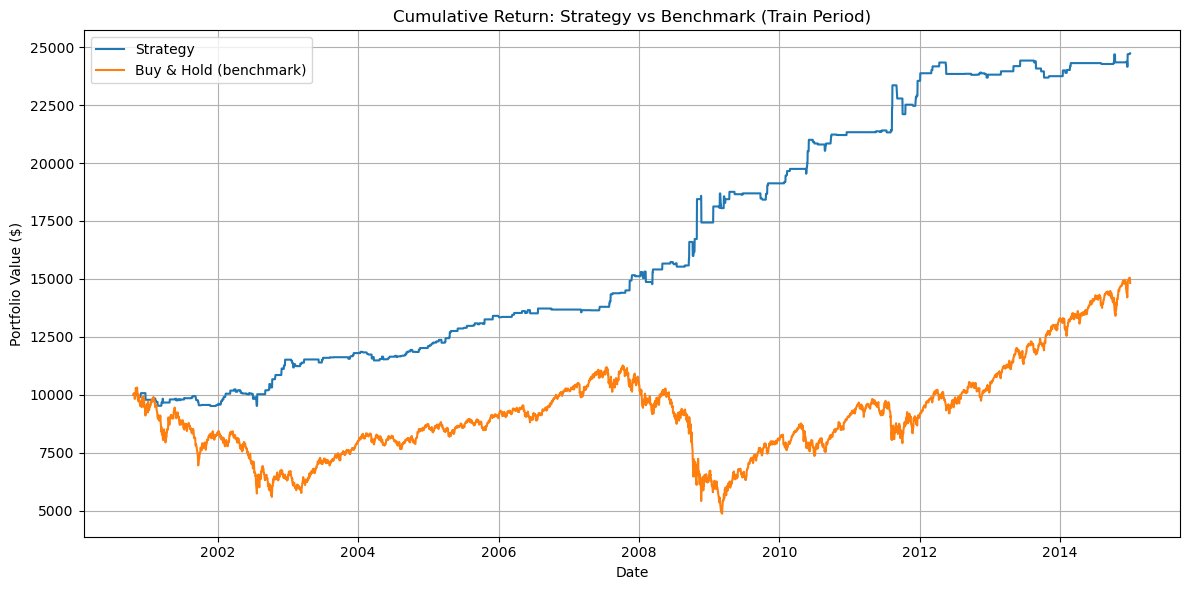

Sharpe Ratio:  1.02
CAGR:  6.59%
Alpha:  0.04
Max DrawDown:  -6.95%
Trade Summary (Train Period)
Total Trades:         280
Win Rate:             63.93%
Average Return:       0.35%
Average Hold Time:    1.00 days
Max Consecutive Losses: 4
Time in Market:       5.40%


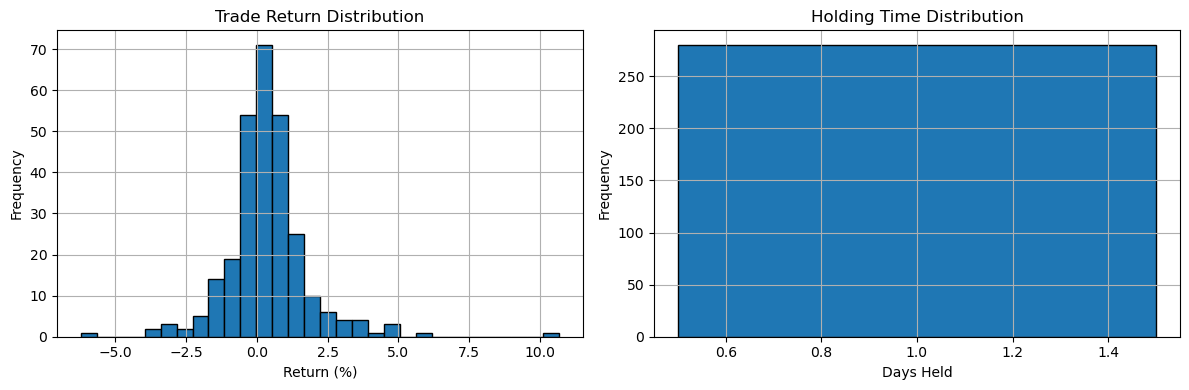

In [2]:
params = {}

def buy_signal(df, i, entry_price, days_held):
        return df["ibs"].iloc[i] < 0.15 and df["ER10"].iloc[i] > 0.28

def sell_signal(df, i, entry_price, days_held):
        return days_held > 0

strategy = BackTesting(
    ticker="^GSPC",
    start_date="2000-01-01",
    end_date="2025-01-01",
    train_end="2015-01-01",
    initial_investment=10000,
    params=params
)

strategy.buy_signal = buy_signal
strategy.sell_signal = sell_signal

strategy.prepare_data()
strategy.run_backtest()
strategy.backtest(period="train")
strategy.summarize_trades("train")